### 13 core implementation details


1.   Vectorized architecture:

  PPO leverages an efficient paradigm known as the vectorized architecture that features a single learner that collects samples and learns from multiple environments.

2.   Layer Initialization:

  Orthogonal Initialization of Weights and Constant Initialization of biases

3. The Adam Optimizer's Epsilon Parameter:

  PPO sets the epsilon parameter to 1e-5

4. Adam Learning Rate Annealing:

  By default, the hyper-parameters for training agents playing Atari games set the learning rate to linearly decay from 2.5e-4 to 0. In MuJoCo, the learning rate linearly decays from 3e-4 to 0.

5. Generalized Advantage Estimation:

  GAE is used to estimate the advantages of taking different actions in a given state. The advantage function measures how much better or worse an action is compared to the average action in that state, and it is a crucial component for updating the policy in PPO.
  Compute the advantage function using the n-step returns and the predicted rewards.

  If a sub-environment is not terminated nor truncated, PPO estimates the value of the next state in this sub-environment as the value target.
  PPO implements the return target as returns = advantages + values, which corresponds to TD(λ) for value estimation.

6. Mini-batch Updates:

  The PPO implementation shuffles the indices of the training data of size N*M and breaks it into mini-batches to compute the gradient and update the policy.

7. Normalization of Advantages:

  PPO normalizes the advantages by subtracting their mean and dividing them by their standard deviation. This normalization happens at the mini-batch level instead of the whole batch level.

8. Clipped surrogate objective

9. Value Function Loss Clipping:

  Given the Vtarg = returns = advantages + values, PPO fits the the value network by minimizing the following loss:

  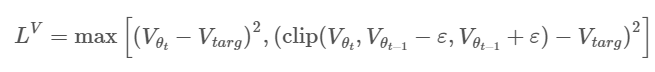

10. Overall Loss and Entropy bonus:

  The overall loss is calculated as

    loss = policy_loss - entropy * entropy_coefficient + value_loss * value_coefficient
  
  which maximizes an entropy bonus term. The policy parameters and value parameters share the same optimizer.

11. Global Gradient Clipping:

  For each update iteration in an epoch, PPO rescales the gradients of the policy and value network so that the global l2 norm does not exceed 0.5.

12. Debug variables:

  The PPO implementation comes with several debug variables, which are:

    * policy_loss: the mean policy loss across all data points.
    * value_loss: the mean value loss across all data points.
    * entropy_loss: the mean entropy value across all data points.
    * clipfrac: the fraction of the training data that triggered the clipped objective.
    * approxkl: the approximate Kullback–Leibler divergence, measured by (-logratio).mean().

13. Shared and separate MLP networks for policy and value functions:

  By default, PPO uses a simple MLP network consisting of two layers of 64 neurons and Hyperbolic Tangent as the activation function. Then PPO builds a policy head and value head that share the outputs of the MLP network.





In [ ]:
import argparse
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

In [ ]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    nn.init.orthogonal_(layer.weight, std)
    nn.init.constant_(layer.bias, bias_const)
    return layer

In [ ]:
class PPOAgent(nn.Module):
    def __init__(self, envs):
        super(PPOAgent, self).__init__()
        self.actor = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, envs.single_action_space.n), std=0.01)
        )

        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0)
        )

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        logits = self.actor(x)
        probs = Categorical(logits=logits) # soft-max distribution

        if action is None:
            action = probs.sample()

        log_prob = probs.log_prob(action)
        entropy = probs.entropy()
        value = self.get_value(x)

        return action, log_prob, entropy, value

In [ ]:
def make_env(env_id, seed, idx, record_video=False):
    def thunk():
        env = gym.make(env_id, render_mode='human')
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if record_video and idx == 0:
            env = gym.wrappers.RecordVideo(env, f"videos/{env_id}")

        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk

In [ ]:
config = argparse.Namespace()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config.env_id = 'CartPole-v1'
config.num_envs = 4
config.num_steps = 128     # The number of steps to run in each env to policy rollout

config.batch_size = config.num_envs * config.num_steps
config.num_minibatches = 4 # the number of mini-batches
config.minibatch_size = config.batch_size // config.num_minibatches

config.total_timesteps = 25000
config.num_updates = config.total_timesteps // config.batch_size
config.num_epochs = 4

config.learning_rate = 3e-4
config.gamma = 0.99
config.anneal_lr = True    # Learning rate annealing for policy and value networks
config.gae= True         # Generalized Advantage Estimation
config.gae_lambda = 0.95

config.norm_adv = True     # Advantages normalization
config.clip_coef = 0.2     # The surrogate clipping coefficient (policy and value function)
config.clip_vloss = True   # Use clip_coef to clip value function

config.vf_coef = 0.5       # The value function coefficient to calculate loss
config.ent_coef = 0.01     # Encourages the policy to explore a diverse set of actions
config.max_grad_norm = 0.5 # The maximum norm for the gradient clipping
config.target_kl = 0.015   # The target KL divergence threshold

config.track = True

Connect to Weights and Biases

In [ ]:
if config.track:
    !pip install wandb

In [ ]:
if config.track:
    import wandb
    wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
if config.track:
    wandb.init(
        project='ppo-implementation-details',
        config=config,
        name=config.env_id,
        monitor_gym=True,
        save_code=True,
    )

In [ ]:
# Seeding
random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)

envs = gym.vector.SyncVectorEnv(
    [make_env(config.env_id, config.seed + i, i, record_video=True) for i in range(config.num_envs)]
)

print("Observation space:", envs.single_observation_space)
print("Action space:", envs.single_action_space)

assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

agent = PPOAgent(envs).to(config.device)
optimizer = optim.Adam(agent.parameters(), lr=config.learning_rate, eps=1e-5)

In [ ]:
def compute_gae_advantages(rewards, values, next_return, dones, num_steps, gamma=0.99, gae_lambda=0.95):
    gae_advantages = torch.zeros_like(rewards)

    gae = 0
    for t in reversed(range(num_steps)):
        delta = rewards[t] + gamma * next_return * (1 - dones[t]) - values[t]
        gae = delta + gamma * gae_lambda * gae * (1 - dones[t])
        gae_advantages[t] = gae
        next_return = values[t]

    returns = gae_advantages + values
    return returns, gae_advantages

In [ ]:
def compute_n_step_return(rewards, values, next_return, dones, num_steps, gamma=0.99):
      returns = torch.zeros_like(rewards)

      for t in reversed(range(num_steps)):
          returns[t] = rewards[t] + gamma * next_return * (1 - dones[t])
          next_return = returns[t]

      advantages = returns - values
      return returns, advantages

In [ ]:
def PPOTrain(envs, optimizer, config):
  global global_step

  # Storage setup
  observations = torch.zeros((config.num_steps, config.num_envs) + envs.single_observation_space.shape).to(config.device)
  actions = torch.zeros((config.num_steps, config.num_envs) + envs.single_action_space.shape, dtype=torch.long).to(config.device)
  rewards = torch.zeros((config.num_steps, config.num_envs)).to(config.device)
  dones = torch.zeros((config.num_steps, config.num_envs)).to(config.device)
  values = torch.zeros((config.num_steps, config.num_envs)).to(config.device)
  logprobs = torch.zeros((config.num_steps, config.num_envs)).to(config.device)

  for update in range(config.num_updates):
      # Update learning rate
      if config.anneal_lr:
          lr_frac = 1.0 - update / config.num_updates
          optimizer.param_groups[0]["lr"] = lr_frac * config.learning_rate

      # Do n-steps
      obs = envs.reset()
      for step in range(config.num_steps):
          global_step += config.num_envs

          with torch.no_grad():
              obs_tensor = torch.Tensor(obs).to(config.device)
              action, logprob, _, value = agent.get_action_and_value(obs_tensor)

          next_obs, reward, done, info = envs.step(action.cpu().numpy())

          # Save batch
          observations[step] = obs_tensor
          actions[step] = torch.Tensor(action, dtype=torch.long).to(config.device)
          rewards[step] = torch.Tensor(reward).to(config.device)
          dones[step] = torch.Tensor(done).to(config.device)
          values[step] = torch.Tensor(value.flatten()).to(config.device)
          logprobs[step] = torch.Tensor(logprob).to(config.device)

          if info.get('episode') is not None:
              episodic_info = info.get('episode')[0]
              if episodic_info is not None:
                  print(f"global_step={global_step}, episodic_return={episodic_info['r']}")
                  wandb.log({'episodic_return': episodic_info['r']})

          obs = next_obs

      # Generalized Advantage Estimation
      with torch.no_grad():
          next_obs_tensor = torch.Tensor(next_obs).to(config.device)
          next_value = agent.get_value(next_obs_tensor).reshape(1, -1)

          if config.gae:
              returns, advantages = compute_gae_advantages(rewards, values, next_value, dones, config.num_steps, config.gamma, config.gae_lambda)
          else:
              returns, advantages = compute_n_step_return(rewards, values, next_value, dones, config.num_steps, config.gamma)

      # Flatten the batch: num_steps * num_envs
      b_observations = observations.reshape((-1,) + envs.single_observation_space.shape)
      b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
      b_returns = returns.reshape(-1)
      b_values = values.reshape(-1)
      b_logprobs = logprobs.reshape(-1)
      b_advantages = advantages.reshape(-1)

      clip_fracs = []

      # Shuffles the indices of the batch and breaks it into mini-batches
      batch_inds = np.arange(config.batch_size)
      for epoch in range(config.num_epochs):
          np.random.shuffle(batch_inds)

          for start in range(0, config.batch_size, config.minibatch_size):
              end = start + config.minibatch_size
              minibatch_inds = batch_inds[start:end]

              # Mini-batches: targets
              mb_observations = b_observations[minibatch_inds]
              mb_actions = b_actions[minibatch_inds]
              mb_returns = b_returns[minibatch_inds]
              mb_values = b_values[minibatch_inds]
              mb_logprobs = b_logprobs[minibatch_inds]
              mb_advantages = b_advantages[minibatch_inds]

              # Advantages normalization
              if config.norm_adv:
                  mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

              # Predictions
              _, mb_logprobs_pred, mb_entropy_pred, mb_values_pred = agent.get_action_and_value(mb_observations, mb_actions)

              log_ratio = mb_logprobs_pred - mb_logprobs
              ratio = log_ratio.exp()

              with torch.no_grad():
                  clip_fracs += [((ratio - 1.0).abs() > config.clip_coef).float().mean().item()]

              # Policy loss
              pg_loss_unclipped = -mb_advantages * ratio
              pg_loss_clipped = -mb_advantages * torch.clamp(ratio, 1 - config.clip_coef, 1 + config.clip_coef)
              pg_loss = torch.max(pg_loss_unclipped, pg_loss_clipped).mean()

              # Value loss
              mb_values_pred = mb_values_pred.view(-1)

              v_loss_sqrt = (mb_values_pred - mb_returns) ** 2 # Unclipped
              if config.clip_vloss:
                  # Ensure that the value function updates do not deviate too far from the original values
                  v_clipped = torch.clamp(mb_values_pred, mb_values - config.clip_coef, mb_values + config.clip_coef)
                  v_loss_clipped = (v_clipped - mb_returns) ** 2
                  v_loss_sqrt = torch.max(v_loss_sqrt, v_loss_clipped)

              v_loss = 0.5 * v_loss_sqrt.mean()

              # Entropy Loss
              entropy_loss = mb_entropy_pred.mean()

              # Overall Loss
              loss = pg_loss - config.ent_coef * entropy_loss + config.vf_coef * v_loss

              optimizer.zero_grad()
              loss.backward()

              # Global Gradient Clipping
              nn.utils.clip_grad_norm_(agent.parameters(), config.max_grad_norm)

              optimizer.step()

          with torch.no_grad():
            # old_approx_kl = (-logratio).mean()
            approx_kl = ((ratio - 1) - log_ratio).mean()

          # Early stop using approx_kl
          if config.target_kl is not None:
                if approx_kl > config.target_kl:
                    break

      y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
      var_y = np.var(y_true)
      explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

      if config.track:
          metrics = {
              "GLOBAL STEP": global_step,
              "loss": loss.item(),
              "learning_rate": optimizer.param_groups[0]["lr"],
              "value_loss": v_loss.item(),
              "policy_loss": pg_loss.item(),
              "entropy": entropy_loss.item(),
              "approx_kl": approx_kl.item(),
              "clip_frac": np.mean(clip_fracs),
              "explained_variance": explained_var
          }
          wandb.log(metrics)
          print(metrics)

In [ ]:
global_step = 0

In [ ]:
PPOTrain(envs, optimizer, config)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:89: UserWarning: WARN: Disabling video recorder because environment <RecordEpisodeStatistics<TimeLimit<OrderEnforcing<StepAPICompatibility<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>>> was not initialized with any compatible video mode between `single_rgb_array` and `rgb_array`
  logger.warn(


global_step=80, episodic_return=20.0
global_step=128, episodic_return=12.0
global_step=184, episodic_return=14.0
global_step=300, episodic_return=29.0
global_step=456, episodic_return=39.0
{'GLOBAL STEP': 512, 'loss': 20.69984245300293, 'learning_rate': 0.0003, 'value_loss': 41.413299560546875, 'policy_loss': 0.00012090802192687988, 'entropy': 0.6928695440292358, 'approx_kl': 0.00027229078114032745, 'clip_frac': 0.0, 'explained_variance': -0.0026308298110961914}
global_step=616, episodic_return=26.0
global_step=668, episodic_return=13.0
global_step=764, episodic_return=24.0
global_step=900, episodic_return=34.0
global_step=1012, episodic_return=28.0
{'GLOBAL STEP': 1024, 'loss': 16.502805709838867, 'learning_rate': 0.00029374999999999996, 'value_loss': 33.03014373779297, 'policy_loss': -0.005356862209737301, 'entropy': 0.6910135746002197, 'approx_kl': 0.0007931031286716461, 'clip_frac': 0.0, 'explained_variance': -0.0010976791381835938}
global_step=1188, episodic_return=41.0
global_ste

In [ ]:
envs.close()
if config.track: wandb.finish()

GLOBAL STEP,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
approx_kl,▂▅▄█▇█▇▄▃▂▂▂▁▂▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
clip_frac,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,███▇▇▆▅▅▄▄▄▄▄▃▃▃▃▂▂▂▃▂▁▂▃▃▃▂▂▃▁▃▂▁▁▂▂▂▂▁
explained_variance,▂▂▂▂▂▂▂▁▂▁▂▃▂▂▃▁▄▁▃▂▅▃▄▅▅▅▄▅▅▆▃▆▂▂▃▂▄▇█▂
learning_rate,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
loss,▂▁▄▂▄▂▅▆▆▅▇▅▅▅▆█▆▇▆▅▇▇▆▇▇▇▆▆▆▇▆▇▅▄▆▆▇▆█▇
policy_loss,▇▄▅▁▅▁▅▃▅▆▆▇▇▅█▆▆▆▆▆▇▆▆▇▇▆▇▆▇▆▇▆▇▆▆▆▇▆▇▇
value_loss,▂▁▄▂▄▂▅▆▆▅▇▅▅▅▆█▆▇▆▅▇▇▆▇▇▇▆▆▆▇▆▇▅▄▆▆▇▆█▇
GLOBAL STEP,24576
approx_kl,0.0
